In [1]:
import numpy as np
import pandas as pd
import scipy.integrate as int
import scipy.optimize as op
import emcee
import matplotlib.pyplot as plt
from scipy import interpolate
import scipy.constants as const
import sys
from astropy.cosmology import wCDM
#from scipy.interpolate import griddata
from astropy.cosmology import FlatLambdaCDM

In [2]:
#inputting data
cc_xdata, cc_ydata, cc_yerr = np.loadtxt('/Users/eoin/Documents/Python/Data/cc.txt',usecols=(0,1,2), unpack=True)
bao_xdata, bao_ydata, bao_yerr = np.loadtxt('/Users/eoin/Documents/Projects/Cosmology/HighZ/bao.dat',usecols=(0,1,2), unpack=True)
zqso0, fUV0, fUVerr0, fX0, fXerr0  = np.loadtxt('/Users/eoin/Documents/Projects/Cosmology/HighZ/qso.txt', usecols=(3, 4, 5, 6, 7), unpack=True)
fUV0 = fUV0+2*np.log10(3.086e+24)
fX0 = fX0 + 2*np.log10(3.086e+24)
np.shape(fUV0)

(2421,)

In [3]:
input_xdata = np.append(cc_xdata, bao_xdata)
input_ydata = np.append(cc_ydata, bao_ydata)
input_yerr = np.append(cc_yerr, bao_yerr)

In [4]:
x = np.logical_and(0.7 < zqso0, zqso0 <= 2.36)
zqso = zqso0[x]
fUV = fUV0[x] 
fUVerr = fUVerr0[x] 
fX = fX0[x] 
fXerr = fXerr0[x]
len(zqso)

1737

In [5]:
x = np.logical_and(0.7 < input_xdata, input_xdata <= 2.36)
xdata = input_xdata[x]
ydata = input_ydata[x]
yerr = input_yerr[x]
len(yerr)

18

In [6]:
def integrand(z, om):
    return 1/np.sqrt(1-om+om*(1+z)**3)

def H(z, h0, om):
    return h0*np.sqrt(1-om + om*(1+z)**3)

def DL(z, h0, om):
    ans = const.c*(1+z)/1000/h0*int.quad(integrand, 0.0, z, args =(om))[0]
    
    return ans

DL = np.vectorize(DL)

In [7]:
def lnlike(u):
    h0 = u[0]
    om = u[1]
    beta = u[2]
    gamma = u[3]
    delta = u[4]
    
    temp = beta+(gamma-1)*np.log10(4*np.pi*DL(zqso, h0, om)**2)+gamma*fUV
    
    qso = -1/2*((temp-fX)**2/(fXerr**2+delta**2)+np.log(2*np.pi*(fXerr**2+delta**2))).sum()
    
    cc = -1/2*((ydata-H(xdata, h0, om))**2/yerr**2).sum()
    
    wm = om*(h0/100)**2
    cmb = -1/2*(wm - 0.1430)**2/0.00000121
    
    return qso+cmb+cc

In [9]:
nll = lambda *args: -lnlike(*args)
result = op.minimize(nll, [70, 0.3, 7, 6, 0.2], bounds = ((0.001, 100), (0,1), (0.001, 15), (0.001,1), (0.001,1)), options={'disp': None, 'maxcor': 10, 'ftol': 2.220446049250313e-15, 'gtol': 1e-05, 'eps': 1e-08, 'maxfun': 15000, 'maxiter': 15000, 'iprint': - 1, 'maxls': 20})
h0, om, b, g, d = result["x"]
print(h0, om, b, g, d)
print((h0/100)**2*om)

37.84729016030816 1.0 8.359465202975509 0.6012246542075534 0.2303214490974637
0.1432417372478559


In [10]:
def lnprior(u):
    h0 = u[0]
    om = u[1]
    beta = u[2]
    gamma = u[3]
    delta = u[4]

    if 0 < h0 < 100 and 0 < om < 1 and 0 < b < 15 and 0 < gamma < 1 and 0 < delta < 1: 
        return 0.0
    return -np.inf

In [11]:
def lnprob(u):
    lp = lnprior(u)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(u)

In [15]:
ndim, nwalkers = 5, 30
pos = [[h0, om, b, g, d] + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]

In [16]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob)

In [ ]:
sampler.run_mcmc(pos, 2500, progress=True);

 15%|█▌        | 387/2500 [11:00<1:02:15,  1.77s/it]

In [14]:
tau = sampler.get_autocorr_time()
print(tau)

[46.58158272 46.4828647  49.22508786 49.14740008 47.01546787]


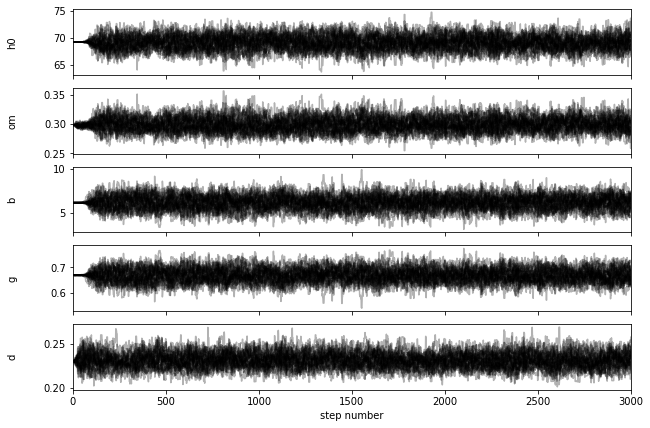

In [15]:
fig, axes = plt.subplots(5, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["h0", "om", "b", "g", "d"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [16]:
samples = sampler.chain[:, 750:, :].reshape((-1, ndim))

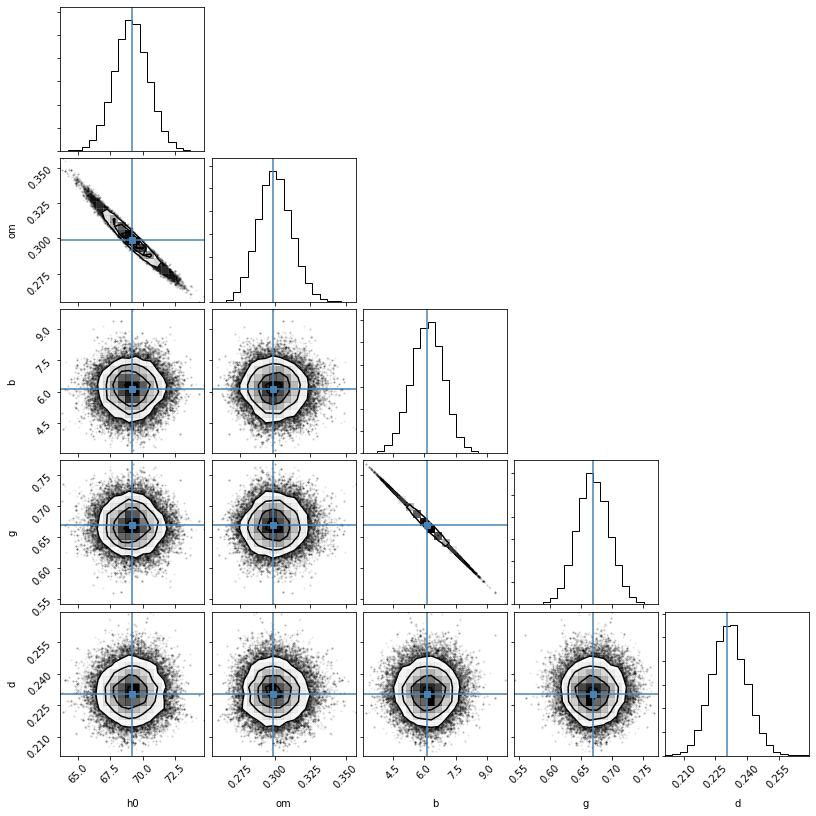

In [20]:
import corner
fig = corner.corner(samples, labels=["h0", "om", "b", "g", "d"], truths=[h0, om, b, g, d])
#fig.savefig("QSO_OHD_CMBprior_zmax07.png")

In [18]:
flat_samples = sampler.get_chain(discard=750, thin=15, flat=True)
print(flat_samples.shape)

(4500, 5)


In [19]:
from IPython.display import display, Math

for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    #err = 1/2*(q[0]+q[1])
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    #txt = "\mathrm{{{2}}} = {0:.2f}\pm{{{1:.2f}}}"
    #txt = txt.format(mcmc[1], err, labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [21]:
#np.savetxt("QSO_OHD_CMBprior_zmax0_MCMCchain.txt", flat_samples)